In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from PIL import Image

def add_noise_to_image(image_array, noise_type='gaussian', **kwargs):
    """
    Добавляет шум к изображению.

    Параметры:
    - image_array: numpy array изображения (нормализовано [0, 1])
    - noise_type: тип шума ('gaussian' или 'salt_pepper')
    - kwargs: параметры шума:
        - sigma (для гауссовского шума)
        - prob (для шума соль-перец)

    Возвращает:
    - Зашумлённое изображение (numpy array)
    """
    if noise_type == 'gaussian':
        sigma = kwargs.get('sigma', 0.1)
        noise = np.random.normal(0, sigma, image_array.shape)
        noisy_image = image_array + noise
        return np.clip(noisy_image, 0, 1)

    elif noise_type == 'salt_pepper':
        prob = kwargs.get('prob', 0.05)
        noisy_image = np.copy(image_array)
        mask = np.random.random(image_array.shape) < prob
        noisy_image[mask] = np.random.randint(0, 2, size=np.sum(mask))
        return noisy_image

    else:
        raise ValueError("Поддерживаемые типы шума: 'gaussian', 'salt_pepper'")

def display_image(image_array, title='', cmap='gray'):
    """Отображает изображение с помощью matplotlib"""
    plt.figure(figsize=(8, 6))
    plt.imshow(image_array, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def total_variation_denoising(v, lambda_param, max_iter=1000, tol=1e-6):
    """
    Реализация ROF модели (Rudin-Osher-Fatemi) для удаления шума с progress bar.

    Параметры:
    v : numpy.ndarray
        Зашумленное изображение (2D массив).
    lambda_param : float
        Параметр регуляризации (λ).
    max_iter : int, optional
        Максимальное количество итераций (по умолчанию 1000).
    tol : float, optional
        Критерий остановки по изменению значения функционала (по умолчанию 1e-6).

    Возвращает:
    numpy.ndarray
        Очищенное изображение (u).
    """
    u = v.copy()
    height, width = v.shape

    # Функция для вычисления градиента
    def gradient(u):
        grad_x = np.roll(u, -1, axis=1) - u
        grad_y = np.roll(u, -1, axis=0) - u
        return grad_x, grad_y

    # Функционал для минимизации
    def functional(u_flat):
        u = u_flat.reshape((height, width))
        grad_x, grad_y = gradient(u)
        tv_term = np.sum(np.sqrt(grad_x**2 + grad_y**2))
        fidelity_term = 0.5 * np.sum((v - u)**2)
        return tv_term + lambda_param * fidelity_term

    # Оптимизация с progress bar
    with tqdm(total=max_iter, desc='TV Denoising Progress', unit='iter') as pbar:
        # Callback функция для обновления progress bar
        def callback(xk):
            pbar.update(1)

        result = minimize(functional,
                         u.flatten(),
                         method='L-BFGS-B',
                         callback=callback,
                         options={'maxiter': max_iter, 'gtol': tol})

    return result.x.reshape((height, width))


In [ ]:
def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):

  """
  Removing noise from images is important for many applications, from making
your personal photos look better to improving the quality of satellite and increasingly
drone images.

In image processing denoising functionally looks like we are smoothing out the image.
but just what is it we are smoothing out to remove the noise?

The ROF model has the interesting property that it finds a smoother version
of the image while preserving edges and structures.

The underlying mathematics of the ROF model and the solution techniques are
quite advanced and are showcased fully in the paper:

Nonlinear total variation based noise removal algorithms*
Leonid I. Rudin 1, Stanley Osher and Emad Fatemi
Cognitech Inc., 2800, 28th Street, Suite 101, Santa Monica, CA 90405, USA. circa 1992.

Its interesting to note that the authors base their work on work done previously
by Geman and Reynolds in which they propse to minimisae the non-linear functionals
asscoaited with noise in the total varience by use of simulated annealing, a
metaheursitics technique, which would have been very slow to do using the computers
available in the late 1980s something
which drove the development of the ROF denoising model in the first place.
The authors wanted a fast solver that could find a reasonably good local minima
rather tha the ideal global minima.

Here I'll give a brief,
simplified introduction before showing how to implement a ROF solver based
on an algorithm by Chambolle.

The solver used in this code is a modified version that uses grdient descent/
reprojection method to achieve total variance (TV) minimization/regularization
The integral of the gradient across an image, any image, will produce the total varience
in tha image. now, for noisy images the total varience will be higher. knowing this,
denoising techniques have been developed that essentially minimise the total varience
in the matrix element of an image and then reproject that image onto the original by substracting
the imaginary form of the original image matrix element which contains the residiual texture
of the image. so textures are effectively removed when we want to do TV minimization/regularization.



To minimise the total varience in the matrix element different algorithms can be used
but one of the most popular is gradient descent, which is simular to the simulated annealing
technique originally proposed but more computationally tractable.


in gradient descent the image matrix containing the greyscale pixel values are
essentially represented as an energy surface, whereby
we want to descend into the global minima. the different values in the matrix represent
the interaction energies of the nearest neighbour in this 2D energy surface.
different algorithms can use
different equations to represent the interaction energies, depending on the rate at which
the interaction energies converge to a global minima in a certain steplength of
iteration of the algorithm.



Interesting Note: When implented using periodic boundary conditions the TV minimization using
an iteractive gradient descent on an image performs 2 transformations on that
images rectangular image domain where the greyscale pixel values exist. 2 transformations
on a rectangle result in the formation of a torus in a transformation which
preserves the images pixel data but changes the domain topology.




    An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
    using the numerical procedure presented in equation 11 on pg 15 of
    A. Chambolle (2005)
    http://www.cmap.polytechnique.fr/preprint/repository/578.pdf


        Input:
        im - noisy input image (grayscale)
        U_init - initial guess for U
        tv_weight - weight of the TV-regularizing term
        tau - steplength in the Chambolle algorithm
        tolerance - tolerance for determining the stop criterion

        Output:
        U - denoised and detextured image (also the primal variable)
        T - texture residual





    Input: noisy input image (grayscale), initial guess for U, weight of
    the TV-regularizing term, steplength, tolerance for stop criterion.

    Output: denoised and detextured image, texture residual. """

  m,n = im.shape # size of noisy image

  # initialize
  U = U_init
  Px = im # x-component to the dual field
  Py = im # y-component of the dual field
  error = 1
  iteration = 0



  while (error > tolerance):
    Uold = U

    # gradient of primal variable
    GradUx = np.roll(U,-1,axis=1)-U # x-component of U's gradient
    GradUy = np.roll(U,-1,axis=0)-U # y-component of U's gradient

    # update the dual varible
    PxNew = Px + (tau/tv_weight)*GradUx
    PyNew = Py + (tau/tv_weight)*GradUy
    NormNew = np.maximum(1,np.sqrt(PxNew**2+PyNew**2))

    Px = PxNew/NormNew # update of x-component (dual)
    Py = PyNew/NormNew # update of y-component (dual)
    """
    the function roll(), which, as the name suggests, “rolls” the values of an array
    cyclically around an axis. This is very convenient for computing neighbor differences,
    in this case for derivatives. We also used linalg.norm(), which measures the difference
    between two arrays (in this case, the image matrices U and Uold).
    """
    # update the primal variable
    RxPx = np.roll(Px,1,axis=1) # right x-translation of x-component
    RyPy = np.roll(Py,1,axis=0) # right y-translation of y-component

    DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
    U = im + tv_weight*DivP # update of the primal variable

    # update of error
    error = np.linalg.norm(U-Uold)/np.sqrt(n*m);

    iteration += 1;

    #The texture residual
  T = im - U
  #print: 'Number of ROF iterations: ', iteration

  return U,T # denoised image and texture residual


In [ ]:

# Загрузка и подготовка изображения
image_path = "logos.png"
original_image = Image.open(image_path).convert("L").resize((100, 100))  # Чёрно-белое
original_array = np.array(original_image, dtype=np.float32) / 255.0  # Нормализуем [0, 1]

# Отображение оригинального изображения
display_image(original_array, title='Original Image')

# Добавление шумов и отображение
noisy_gaussian = add_noise_to_image(original_array, noise_type='gaussian', sigma=0.4)
display_image(noisy_gaussian, title='Gaussian Noise')

noisy_salt_pepper = add_noise_to_image(original_array, noise_type='salt_pepper', prob=0.05)
display_image(noisy_salt_pepper, title='Salt & Pepper Noise')

# Очистка от шума и отображение результатов
denoised_gaussian = total_variation_denoising(noisy_gaussian, lambda_param=0.5, max_iter=100, tol=1e-6)
display_image(denoised_gaussian, title='Denoised (Gaussian)')

denoised_salt_pepper = total_variation_denoising(noisy_salt_pepper, lambda_param=0.5, max_iter=100, tol=1e-6)
display_image(denoised_salt_pepper, title='Denoised (Salt & Pepper)')

In [ ]:
# 1. Загрузите изображение и преобразуйте в grayscale
image = Image.open("Lisa.jpg").convert("L")
im = np.array(image, dtype=np.float32) / 255.0  # Нормализация [0,1]



In [ ]:
# 2. Добавьте шум (опционально)
noisy_im = im + np.random.normal(0, 0.6, im.shape)  # Гауссовский шум
noisy_im = np.clip(noisy_im, 0, 1)


display_image(noisy_im, title='Noise')

In [ ]:
# 3. Примените denoise()
U, T = denoise(
    im=noisy_im,          # Зашумленное изображение
    U_init=noisy_im,      # Начальное приближение (обычно копия зашумленного)
    tolerance=0.0023,        # Критерий остановки (чем меньше, тем точнее)
    tau=0.125,            # Длина шага алгоритма (0 < tau < 0.25)
    tv_weight=1        # Вес TV-регуляризации (чем больше, тем сильнее сглаживание)
)
# 4. Визуализируйте результаты
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(noisy_im, cmap='gray'); plt.title("Noisy")
plt.subplot(132); plt.imshow(U, cmap='gray'); plt.title("Denoised")
plt.subplot(133); plt.imshow(T, cmap='gray'); plt.title("Texture/Noise")
plt.show()

In [ ]:
# 1. Загрузите изображение и преобразуйте в grayscale
image = Image.open("rentgen.jpg").convert("L")
im = np.array(image, dtype=np.float32) / 255.0  # Нормализация [0,1]
U2, T2 = denoise(
    im=im,          # Зашумленное изображение
    U_init=im,      # Начальное приближение (обычно копия зашумленного)
    tolerance=0.001,        # Критерий остановки (чем меньше, тем точнее)
    tau=0.125,            # Длина шага алгоритма (0 < tau < 0.25)
    tv_weight=4        # Вес TV-регуляризации (чем больше, тем сильнее сглаживание)
)
plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(im, cmap='gray'); plt.title("Noisy")
plt.subplot(132); plt.imshow(U2, cmap='gray'); plt.title("Denoised")
plt.subplot(133); plt.imshow(T2, cmap='gray'); plt.title("Texture/Noise")
plt.show()

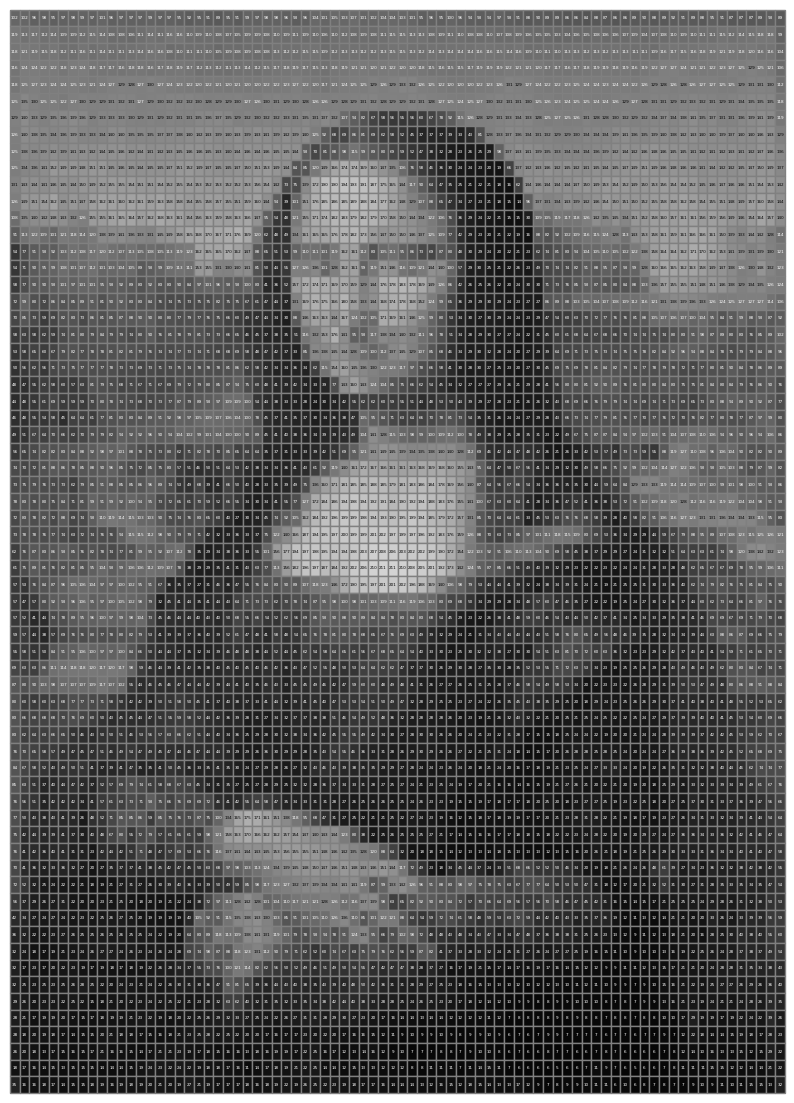

In [20]:
import cv2
import matplotlib.pyplot as plt

# Загрузка и уменьшение изображения
imG = cv2.imread('lisa.jpg', cv2.IMREAD_GRAYSCALE)
small_imG = cv2.resize(imG, (80, 65), interpolation=cv2.INTER_AREA)  # Уменьшаем до 20x20

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

table = ax.table(
    cellText=small_imG,
    cellColours=[[f'#{val:02x}{val:02x}{val:02x}' for val in row] for row in small_imG],
    loc='center',
    cellLoc='center'
)

# Фиксированный размер шрифта (чтобы избежать auto_set_font_size)
for cell in table.get_celld().values():
    val = int(cell.get_text().get_text() or 0)
    text_color = 'white' if val < 128 else 'black'
    cell.set_color(f'#{val:02x}{val:02x}{val:02x}')
    cell.get_text().set_color(text_color)
    cell.set_edgecolor('gray')
    cell.set_fontsize(8)  # Фиксируем размер шрифта

plt.savefig('Lisa_GTable.png', dpi=300, bbox_inches='tight')
plt.show()

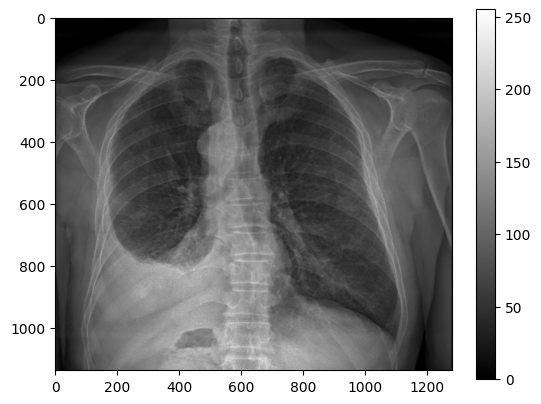

In [8]:
plt.imshow(imG, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()